## Roadmap
- [x] load data into a tf dataset in memory 
- [x] create a dummy MLP and training loop
- [x] debug MLP on linear regression
- [x] Add dummy regularization and make it a baby resnet
    - Going for dropout and weight decay
- [x] Split code nicely into several files
- Apply Karpathy's guide on dummy data and then on normal data
- [ ] Unit tests
    - Understand how to specify neural net parameters init
    - Understand init rngs and nn.module
    - debug simple resnet training
- [ ] Checkpointing and evaluation
- [ ] Tensorboard
- [ ] Baby version submission
- [ ] GPU training on AWS
- [ ] Rayon for training on several instances at the same time
- [ ] Go all in on hyperparameters tuning

### Notes
- Understand `nn.compact`
- Check out the source code for their train state

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp
import optax

from data_loader import get_dataset
from models import MLP, Resnet
from train import train, init_params
from utils import poisson_loss, squared_loss

#### Load training data

In [2]:
n1, n2 = 1000, 10

exp_seed = random.PRNGKey(15)
exp_seed, out1_key, out2_key, out3_key= random.split(exp_seed, 4)

In [3]:
X_train = random.normal(out1_key, shape=(n1, n2))
noise = random.normal(out2_key, shape=(n1,))
beta = 2 * (random.uniform(out3_key, shape=(n2,)) - 0.5)
bias = 15.0
Y_train = X_train.dot(beta) + noise + bias

### 1. make one with the data

(array([ 11.,  37.,  87., 152., 208., 217., 167.,  89.,  24.,   8.]),
 array([ 8.766335, 10.028314, 11.290293, 12.552271, 13.81425 , 15.076229,
        16.338207, 17.600187, 18.862165, 20.124146, 21.386124],
       dtype=float32),
 <BarContainer object of 10 artists>)

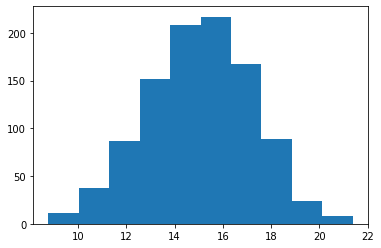

In [4]:
plt.hist(Y_train)

In [27]:
Y_train.std()

DeviceArray(2.1840475, dtype=float32)

In [5]:
X_train.mean(0), X_train.std(0)

(DeviceArray([ 0.01137057,  0.01005887,  0.01693998, -0.05002026,
              -0.01076224, -0.0156854 , -0.02256254,  0.00553981,
              -0.0200922 , -0.00961938], dtype=float32),
 DeviceArray([0.99739987, 0.9881106 , 1.0309198 , 0.9692272 , 0.9714178 ,
              1.0113798 , 0.9474586 , 0.99501777, 1.0120884 , 1.0414252 ],            dtype=float32))

### 2. Init sanity

- init random seed
- no fanciness (think regularization), yet
- actual loss printing
- correct init please
- loss at init
- human baseline -> no need on my synthetic data, I know the upper and lower bounds of perf
- input indep baseline -> we should converge to the mean
- overfit one batch
- verify decreasing training loss
- visualize just before the net
- visualize prediction dynamics
- use backprop to sanity check interactions

In [6]:
p, m = X_train.shape[1], Y_train.shape[0]
p, m

(10, 1000)

In [28]:
n_hidden_layers = 2
layer_size = p

lr = 1e-1  # learning rate
num_epochs = 50
batch_size = 10000

jax_squared = jax.vmap(jax.jit(squared_loss), in_axes=0)

p, m

(10, 1000)

In [29]:
model = Resnet([layer_size for _ in range(n_hidden_layers)] + [1])
optim = optax.adam(lr)

- dummy input check that we have something around what we expect
- viz just before the net (every so often, in tensorboard?)

In [30]:
key, apply_rng = random.split(random.PRNGKey(123412514533214), 2)
dumb_input = random.normal(key, (p,))
dumb_input

DeviceArray([ 1.2285439e-01, -2.2604983e+00, -6.1609256e-01,
              1.0130738e+00,  7.8659046e-01,  2.1171515e-01,
              3.4737816e-01, -7.7392661e-04,  6.0562211e-01,
             -1.7524540e-01], dtype=float32)

In [31]:
biased_params = init_params(apply_rng, model, (p,), bias, str(n_hidden_layers))
model.apply(biased_params, dumb_input)

DeviceArray([15.695716], dtype=float32)

In [ ]:
trained_params = train(rng=random.PRNGKey(1515),
      model=model,
      optimizer=optim,
      dataset=get_dataset(X_train, Y_train, batch_size=batch_size, single_batch=True),
      loss_fn=jax_squared,
      metric_fn=jax_squared,
      num_epochs=num_epochs,
      inputs_shape=(p,),
      bias=bias,
      layer_name=str(n_hidden_layers)
     )

Step 1, Metric: 2.391, Loss: 5.718
Step 1, Metric: 1.674, Loss: 2.801
Step 1, Metric: 1.382, Loss: 1.909
Step 1, Metric: 1.392, Loss: 1.937
Step 1, Metric: 1.117, Loss: 1.247
Step 1, Metric: 1.148, Loss: 1.317
Step 1, Metric: 1.183, Loss: 1.400
Step 1, Metric: 1.147, Loss: 1.315
Step 1, Metric: 1.095, Loss: 1.200
Step 1, Metric: 1.099, Loss: 1.207
Step 1, Metric: 1.082, Loss: 1.171
Step 1, Metric: 1.021, Loss: 1.043
Step 1, Metric: 1.005, Loss: 1.010
Step 1, Metric: 1.013, Loss: 1.027
Step 1, Metric: 1.003, Loss: 1.006
Step 1, Metric: 1.002, Loss: 1.004
Step 1, Metric: 0.998, Loss: 0.996
Step 1, Metric: 0.984, Loss: 0.968
Step 1, Metric: 0.990, Loss: 0.979
Step 1, Metric: 0.983, Loss: 0.966
Step 1, Metric: 0.968, Loss: 0.937
Step 1, Metric: 0.970, Loss: 0.942
Step 1, Metric: 0.970, Loss: 0.940
Step 1, Metric: 0.964, Loss: 0.930
Step 1, Metric: 0.964, Loss: 0.929
Step 1, Metric: 0.958, Loss: 0.917
Step 1, Metric: 0.955, Loss: 0.912
Step 1, Metric: 0.957, Loss: 0.915
Step 1, Metric: 0.94

In [21]:
beta

DeviceArray([ 0.004987  ,  0.6971359 ,  0.7703917 , -0.7560258 ,
             -0.3874371 , -0.6109004 ,  0.26761937, -0.39852762,
             -0.5904341 ,  0.998075  ], dtype=float32)

In [13]:
test_key = random.PRNGKey(12097341324)
test_input = random.normal(test_key, shape=(10,))
test_input.dot(beta)

DeviceArray(0.6110528, dtype=float32)

In [14]:
void_resnet = Resnet([10, 1])

void_resnet.init(test_key, test_input)

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.20926918, -0.01068525,  0.15101431, -0.28913864,
                          -0.2387641 , -0.45487297,  0.28557947, -0.07649882,
                          -0.12096991, -0.01703089],
                         [-0.67760056,  0.09202313, -0.09294838, -0.67426246,
                           0.02269693, -0.36098477, -0.33583322, -0.00211759,
                          -0.5865531 ,  0.3732147 ],
                         [-0.19012551,  0.43210122,  0.15709919, -0.6090087 ,
                          -0.11697897,  0.30257472,  0.33299333, -0.4752703 ,
                           0.11094531, -0.11588252],
                         [ 0.38062447, -0.55905503, -0.02018812,  0.58276933,
                          -0.6763193 , -0.37450963, -0.16405725,  0.24992332,
                           0.22041853, -0.5372677 ],
                         [ 0.5582964 ,  0.03248841,  0.32550335,  0.1469218 ,
                          -0.118

In [15]:
void_resnet.apply(trained_params, test_input, train=False)

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "kernel" in "/Dense_1": (10, 10), (10, 1). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)